In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

tf.version.VERSION

'2.6.0'

In [2]:
datasets = tfds.load('cifar100')

In [3]:
# hyperparameters

# DATA
BUFFER_SIZE = 1024
BATCH_SIZE = 64
IMAGE_SIZE = 144
NUM_CLASSES = 100

# AUGMENTATION
LARGE_IMAGE_SIZE = 200

PATCH_SIZE = 9
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

# OPTIMIZER
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001

# TRAINING
EPOCHS = 50

# ARCHITECTURE
LAYER_NORM_EPS = 1e-6
TRANSFORMER_LAYERS = 8
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]
MLP_HEAD_UNITS = [2048, 1024]

In [4]:
def normalize_image(image):
    image = tf.cast(image, tf.float32)
    return image / 255.0


def augmentation(entry):
    image = entry['image']
    image = tf.image.random_flip_left_right(image)
    image = tf.image.resize(image, (LARGE_IMAGE_SIZE, LARGE_IMAGE_SIZE))
    image = tf.image.random_crop(image, (IMAGE_SIZE, IMAGE_SIZE, 3))
    image = normalize_image(image)
    return image, entry['label']


def preprocess(entry):
    image = entry['image']
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = normalize_image(image)
    return image, entry['label']


train_ds = datasets['train'].shuffle(BUFFER_SIZE).map(augmentation).batch(BATCH_SIZE)
test_ds = datasets['test'].map(preprocess).batch(BATCH_SIZE)

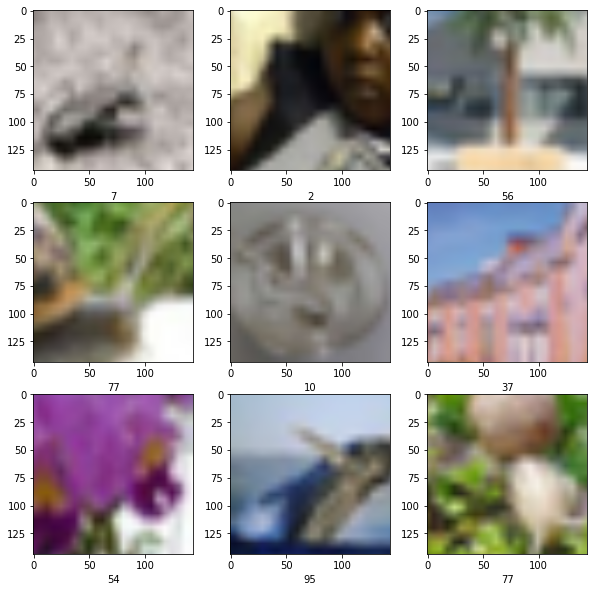

In [5]:
def show_image(ds):
    for entry in ds.take(1):
        images, labels = entry
        for i in range(9):
            plt.subplot(3, 3, i+1)
            image = images.numpy()[i, ...]
            label = labels.numpy()[i]
            plt.imshow(image)
            plt.xlabel(str(label))


plt.figure(figsize=(10, 10))
show_image(train_ds)
plt.show()

ORIGINAL


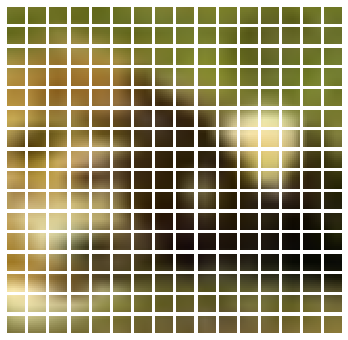

LEFT-UP


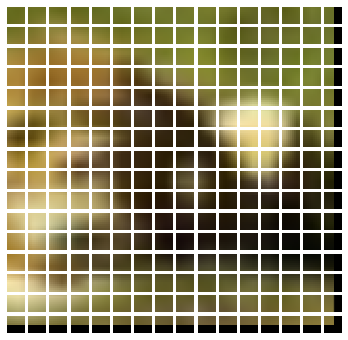

LEFT-DOWN


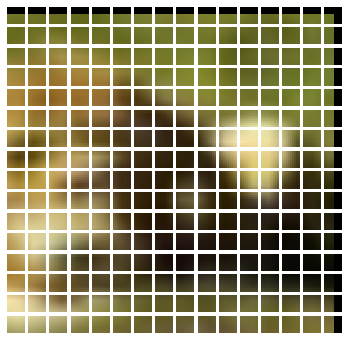

RIGHT-UP


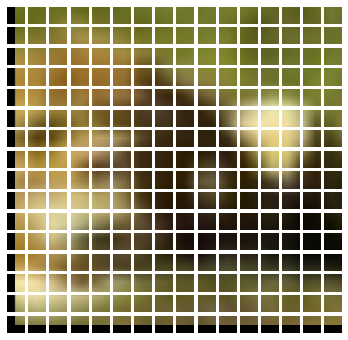

RIGHT-DOWN


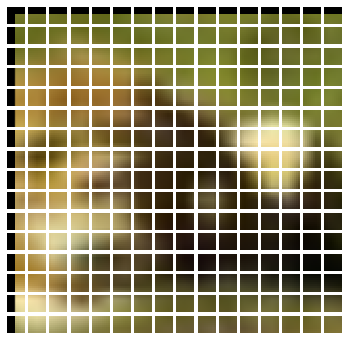

In [6]:
def crop_and_shift(images, half_patch, mode):
    if mode == 'left-up':
        crop_height = half_patch
        crop_width = half_patch
        shift_height = 0
        shift_width = 0
    elif mode == 'left-down':
        crop_height = 0
        crop_width = half_patch
        shift_height = half_patch
        shift_width = 0
    elif mode == 'right-up':
        crop_height = half_patch
        crop_width = 0
        shift_height = 0
        shift_width = half_patch
    else:
        crop_height = 0
        crop_width = 0
        shift_height = half_patch
        shift_width = half_patch
    
    crop = tf.image.crop_to_bounding_box(
        images,
        offset_height=crop_height,
        offset_width=crop_width,
        target_height=IMAGE_SIZE - half_patch,
        target_width=IMAGE_SIZE - half_patch)
    shift_pad = tf.image.pad_to_bounding_box(
        crop,
        offset_height=shift_height,
        offset_width=shift_width,
        target_height=IMAGE_SIZE,
        target_width=IMAGE_SIZE)
    return shift_pad


def shift_patch(images):
    half_patch = PATCH_SIZE // 2
    # Concat the shifted images with the original image
    images = tf.concat([
        images,
        crop_and_shift(images, half_patch, mode="left-up"),
        crop_and_shift(images, half_patch, mode="left-down"),
        crop_and_shift(images, half_patch, mode="right-up"),
        crop_and_shift(images, half_patch, mode="right-down")
    ], axis=-1)
    
    patches = tf.image.extract_patches(
        images=images,
        sizes=[1, PATCH_SIZE, PATCH_SIZE, 1],
        strides=[1, PATCH_SIZE, PATCH_SIZE, 1],
        rates=[1, 1, 1, 1],
        padding="VALID",
    )
    
    flat_patches = layers.Reshape((NUM_PATCHES, -1))(patches)
    
    tokens = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(flat_patches)
    tokens = layers.Dense(units=PROJECTION_DIM)(tokens)
    return tokens, patches


def show_patches(ds):
    shifted_images = ["ORIGINAL", "LEFT-UP", "LEFT-DOWN", "RIGHT-UP", "RIGHT-DOWN"]
    for entry in ds.take(1):
        images, label = entry
        token, patch = shift_patch(images)
        n = patch.shape[1]
        
        for index, patch_name in enumerate(shifted_images):
            print(patch_name)
            plt.figure(figsize=(6, 6))
            count = 1
            for r in range(n):
                for c in range(n):
                    plt.subplot(n, n, count)
                    count += 1
                    image = tf.reshape(patch[0, r, c], (PATCH_SIZE, PATCH_SIZE, 3 * 5))
                    plt.imshow(image[..., 3 * index : 3 * index + 3])
                    plt.axis("off")
            plt.show()


show_patches(train_ds)

In [7]:
def position_embedding(x):   
    pos_embedding = layers.Embedding(input_dim=NUM_PATCHES, output_dim=PROJECTION_DIM)
    positions = tf.range(start=0, limit=NUM_PATCHES, delta=1)
    encoded_positions = pos_embedding(positions)
    encoded_patches = x + encoded_positions
    return encoded_patches


class MultiHeadAttentionLSA(keras.layers.MultiHeadAttention):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # The trainable temperature term. The initial value is
        # the square root of the key dimension.
        self.tau = tf.Variable(np.sqrt(float(self._key_dim)), trainable=True, dtype=tf.float32)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(
            attention_scores, training=training
        )
        attention_output = tf.einsum(
            self._combine_equation, attention_scores_dropout, value
        )
        return attention_output, attention_scores

    
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


def create_vit_classifier():
    inputs = layers.Input(shape=[IMAGE_SIZE, IMAGE_SIZE, 3])
    tokens, _ = shift_patch(inputs)
    encoded_patches = position_embedding(tokens)
    
    diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
    diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)
    
    for _ in range(TRANSFORMER_LAYERS):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = MultiHeadAttentionLSA(
            num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
        )(x1, x1, attention_mask=diag_attn_mask)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, TRANSFORMER_UNITS, 0.1)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    features = mlp(representation, hidden_units=MLP_HEAD_UNITS, dropout_rate=0.5)
    logits = layers.Dense(NUM_CLASSES)(features)
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


keras.backend.clear_session()
model = create_vit_classifier()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 144, 144, 3) 0                                            
__________________________________________________________________________________________________
tf.image.crop_to_bounding_box ( (None, 140, 140, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.image.crop_to_bounding_box_1 (None, 140, 140, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.image.crop_to_bounding_box_2 (None, 140, 140, 3)  0           input_1[0][0]                    
______________________________________________________________________________________________

In [8]:
# Some code is taken from:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2.
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)
        
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")
        
        if self.learning_rate_base < self.warmup_learning_rate:
            raise ValueError(
                "Learning_rate_base must be larger or equal to "
                "warmup_learning_rate."
            )

    def __call__(self, step):
        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)
        
        if self.warmup_steps > 0:
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


def run_experiment(model):
    total_steps = int((len(train_ds) / BATCH_SIZE) * EPOCHS)
    warmup_epoch_percentage = 0.10
    warmup_steps = int(total_steps * warmup_epoch_percentage)
    scheduled_lrs = WarmUpCosine(
        learning_rate_base=LEARNING_RATE,
        total_steps=total_steps,
        warmup_learning_rate=0.0,
        warmup_steps=warmup_steps,
    )

    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    history = model.fit(
        train_ds,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=test_ds,
    )
    return history


keras.backend.clear_session()
model = create_vit_classifier()
history = run_experiment(model)

Epoch 1/50
782/782 [==============================] - 123s 150ms/step - loss: 4.6406 - accuracy: 0.0209 - top-5-accuracy: 0.0894 - val_loss: 4.3272 - val_accuracy: 0.0438 - val_top-5-accuracy: 0.1644
Epoch 2/50
782/782 [==============================] - 118s 151ms/step - loss: 4.3787 - accuracy: 0.0354 - top-5-accuracy: 0.1407 - val_loss: 4.2353 - val_accuracy: 0.0673 - val_top-5-accuracy: 0.2377
Epoch 3/50
782/782 [==============================] - 117s 149ms/step - loss: 4.2855 - accuracy: 0.0470 - top-5-accuracy: 0.1781 - val_loss: 4.0328 - val_accuracy: 0.0792 - val_top-5-accuracy: 0.2641
Epoch 4/50
782/782 [==============================] - 117s 150ms/step - loss: 4.1541 - accuracy: 0.0610 - top-5-accuracy: 0.2221 - val_loss: 3.9611 - val_accuracy: 0.0906 - val_top-5-accuracy: 0.2989
Epoch 5/50
782/782 [==============================] - 118s 150ms/step - loss: 4.0568 - accuracy: 0.0746 - top-5-accuracy: 0.2579 - val_loss: 3.8464 - val_accuracy: 0.1082 - val_top-5-accuracy: 0.3343


Epoch 42/50
782/782 [==============================] - 116s 148ms/step - loss: 2.9278 - accuracy: 0.2696 - top-5-accuracy: 0.5743 - val_loss: 2.8219 - val_accuracy: 0.2948 - val_top-5-accuracy: 0.5968
Epoch 43/50
782/782 [==============================] - 116s 148ms/step - loss: 2.8962 - accuracy: 0.2746 - top-5-accuracy: 0.5814 - val_loss: 2.8911 - val_accuracy: 0.2873 - val_top-5-accuracy: 0.5787
Epoch 44/50
782/782 [==============================] - 116s 148ms/step - loss: 2.8722 - accuracy: 0.2814 - top-5-accuracy: 0.5866 - val_loss: 2.7917 - val_accuracy: 0.3029 - val_top-5-accuracy: 0.5987
Epoch 45/50
782/782 [==============================] - 113s 145ms/step - loss: 2.8284 - accuracy: 0.2876 - top-5-accuracy: 0.5965 - val_loss: 2.8571 - val_accuracy: 0.2860 - val_top-5-accuracy: 0.5808
Epoch 46/50
782/782 [==============================] - 112s 143ms/step - loss: 2.8047 - accuracy: 0.2939 - top-5-accuracy: 0.6009 - val_loss: 2.7171 - val_accuracy: 0.3150 - val_top-5-accuracy: 0.

In [9]:
_, accuracy, top_5_accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

157/157 [==============================] - 11s 67ms/step - loss: 2.6114 - accuracy: 0.3379 - top-5-accuracy: 0.6428
Test accuracy: 33.79%
Test top 5 accuracy: 64.28%
